# Speech Enhancement with CNNs

In [2]:
import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

import time
import copy

In [3]:
sample_rate = 16000           
n_fft = 512
hop = 256
win = 512
window = "hann"

clean_dir = "data/clean"
noise_dir = "data/noise"
noisy_dir = "data/mixed_noisy"

target_snr_db = [10, 5, 0, -5]

eps = 1e-12

# Random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Data Preparation

### Mixing

In [3]:
def add_noise(clean, noise, snr_db):
    """
    Add noise to clean based on the specified SNR
    """
    # Make sure clean and noise have the same length
    min_len = min(len(clean), len(noise))
    clean = clean[:min_len]
    noise = noise[:min_len]

    # Calculate the power
    power_clean = np.mean(clean ** 2) + eps  # eps: Avoid divided by 0
    power_noise = np.mean(noise ** 2) + eps
    
    # Set noise to the specified SNR
    target_ratio = 10 ** (snr_db / 10)  # power_clean / power_noise * scale**2
    scale = np.sqrt(power_clean / (power_noise * target_ratio))
    
    noisy = clean + scale * noise

    # Avoid noisy > 1
    max_val = max(np.max(np.abs(clean)), np.max(np.abs(noisy)), eps)
    clean = clean / max_val
    noisy = noisy / max_val
    
    return clean, noisy

In [4]:
# File path
clean_files = [
    os.path.join(clean_dir, f)
    for f in os.listdir(clean_dir)
    if f.endswith(".wav")
]

noise_files = sorted([
    os.path.join(noise_dir, f)
    for f in os.listdir(noise_dir)
    if f.endswith(".wav")
])

In [5]:
# # Generate a white noise with the same length
# white_noise = np.random.randn(sample_rate * 60 * 5)
# noise_list.append(white_noise)

In [6]:
# Load all noise files

noise_waves_files = []

for noise_path in noise_files:
    noise_wave, _ = librosa.load(noise_path, sr=sample_rate, mono=True)
    noise_waves_files.append(noise_wave)
    print(f"  Loaded noise: {noise_path}, len={len(noise_wave)}")

  Loaded noise: data/noise\noise_351740_spacecraft-background.wav, len=3385981
  Loaded noise: data/noise\noise_425964_amb-transmilenio-city-bus.wav, len=3655007
  Loaded noise: data/noise\noise_553776_water-fall-at-teas-river.wav, len=3732480
  Loaded noise: data/noise\noise_593973_quiet-town-traffic-and-ambience.wav, len=4840887
  Loaded noise: data/noise\noise_644984_electric-fan-contact-mic-long.wav, len=2880003
  Loaded noise: data/noise\noise_698538_recording-on-a-walk.wav, len=4347009
  Loaded noise: data/noise\noise_725423_gentle-white-noise-air-tone.wav, len=11716302
  Loaded noise: data/noise\noise_811852_maribor-fountain-and-helicopter.wav, len=2849940


In [7]:
# Mix clean with noise on different SNR

clean_wave_list = []
noisy_wave_list = []

for clean_path in clean_files:
    # Load clean files
    clean_wave, _ = librosa.load(clean_path, sr=sample_rate, mono=True)
    print(f"Loaded clean: {clean_path}, len={len(clean_wave)}")

    # Add noise
    for noise_wave in noise_waves_files:
        for snr_db in target_snr_db:
            # Randomly select a clip from noise with the same length as the clean
            max_start = len(noise_wave) - len(clean_wave)
            if max_start <= 0:
                start = 0
            else:
                start = np.random.randint(0, max_start + 1)
            noise_seg = noise_wave[start:start + len(clean_wave)]

            # Mix
            clean_aligned, noisy_mix = add_noise(clean_wave, noise_seg, snr_db)

            clean_wave_list.append(clean_aligned)
            noisy_wave_list.append(noisy_mix)

Loaded clean: data/clean\speech_20130318.wav, len=1585941
Loaded clean: data/clean\speech_20160126.wav, len=1619249
Loaded clean: data/clean\speech_20250429.wav, len=1133460
Loaded clean: data/clean\speech_20250805.wav, len=1617463
Loaded clean: data/clean\speech_20250923.wav, len=1208383
Loaded clean: data/clean\speech_20251027.wav, len=718660
Loaded clean: data/clean\speech_20251119_01.wav, len=267967
Loaded clean: data/clean\speech_20251119_02.wav, len=368091
Loaded clean: data/clean\speech_20251119_03.wav, len=778241
Loaded clean: data/clean\speech_20251119_04.wav, len=1136000


In [8]:
# Check the numbers of the clean and noisy
print(len(clean_wave_list))
print(len(noisy_wave_list))

320
320


### STFT

In [9]:
def stft_mag_phase(wave):
    stft = librosa.stft(
        wave,
        n_fft=n_fft,
        hop_length=hop,
        win_length=win,
        window=window
    )
    mag = np.abs(stft)
    phase = np.angle(stft)
    return mag, phase

In [10]:
# STFT on clean
clean_mag_list = []

for c in clean_wave_list:
    clean_mag, _ = stft_mag_phase(c)  # [257, T]
    clean_mag_list.append(clean_mag)

    print("clean_mag shape:", clean_mag.shape)

clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6326)
clean_mag shape: (257, 6326)
clean_mag shap

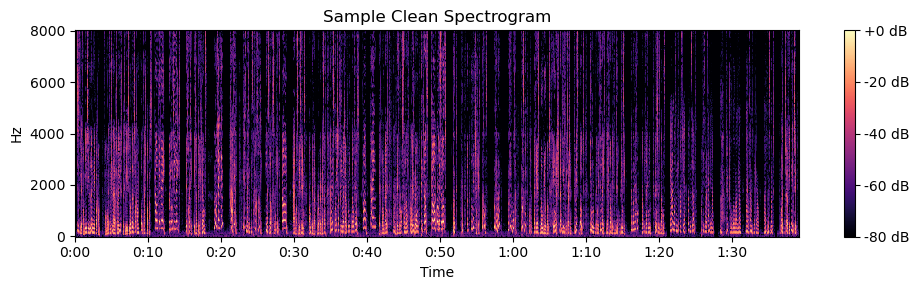

In [11]:
# Plot the first clean magnitude spectrogram just to take a look

sample_clean_mag = clean_mag_list[0]

plt.figure(figsize=(10, 3))
librosa.display.specshow(
    librosa.amplitude_to_db(sample_clean_mag, ref=np.max),  # Max amplitude reference as 0 dB
    sr=sample_rate,
    hop_length=hop,
    y_axis="linear",
    x_axis="time"
)
plt.title("Sample Clean Spectrogram")
plt.colorbar(format="%+2.0f dB")  # Magnitude unit on colorbar
plt.tight_layout()
plt.show()

In [12]:
# STFT on noise
noisy_mag_list = []
noisy_phase_list = []

for nc in noisy_wave_list:
    noisy_mag, noisy_phase = stft_mag_phase(nc)

    noisy_mag_list.append(noisy_mag)
    noisy_phase_list.append(noisy_phase)

    print(f"noisy_mag shape:", noisy_mag.shape)

noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6196)
noisy_mag shape: (257, 6326)
noisy_mag shape: (257, 6326)
noisy_mag shap

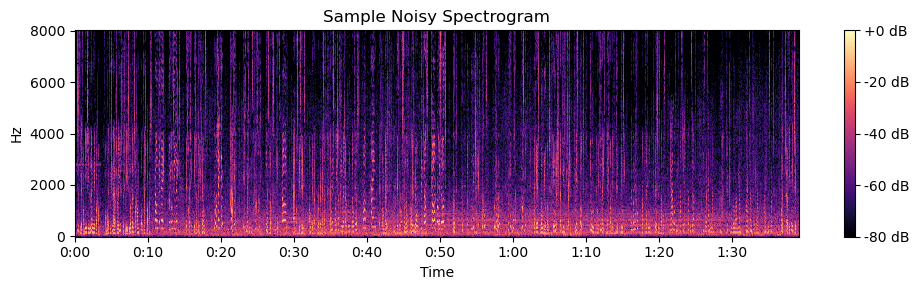

In [13]:
# Plot one of the noisy magnitude spectrograms

sample_noisy_mag = noisy_mag_list[4]

plt.figure(figsize=(10, 3))
librosa.display.specshow(
    librosa.amplitude_to_db(sample_noisy_mag, ref=np.max),  # Max amplitude reference as 0 dB
    sr=sample_rate,
    hop_length=hop,
    y_axis="linear",
    x_axis="time"
)
plt.title("Sample Noisy Spectrogram")
plt.colorbar(format="%+2.0f dB")  # Magnitude unit on colorbar
plt.tight_layout()
plt.show()

In [14]:
# Cut the mag into small time patches
patch_time = 96  # 96 time frames per patch
hop_time = 48  # 50% overlaping

noisy_patches_list = []
clean_patches_list = []

for cm in clean_mag_list:
    # Ensure the frequency dimension matches the expected number of frequency bins
    freq_bins, time_total = cm.shape
    assert freq_bins == n_fft // 2 + 1, "Frequency dimension doesn't match."
    print(f"clean_mag shape: {cm.shape}")

    # Cut clean
    t = 0
    while t + patch_time <= time_total:  # Short clips will be ignored
        clean_patch = cm[:, t:t+patch_time]    # [257, 96]
    
        # Add a channel dimension
        clean_patches_list.append(clean_patch[None, :, :])  # [1, 257, 96]
    
        t += hop_time

for nm in noisy_mag_list:
    freq_bins, time_total = nm.shape
    assert freq_bins == n_fft // 2 + 1, "Frequency dimension doesn't match."
    print(f"noisy_mag shape: {nm.shape}")

    # Cut noisy
    t = 0
    while t + patch_time <= time_total:
        noisy_patch = nm[:, t:t+patch_time]      # [257, 96]
    
        # Add a channel dimension
        noisy_patches_list.append(noisy_patch[None, :, :])  # [1, 257, 96]
    
        t += hop_time


clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6196)
clean_mag shape: (257, 6326)
clean_mag shape: (257, 6326)
clean_mag shap

In [15]:
print("num clean patches:", len(clean_patches_list))
print("num noisy patches:", len(noisy_patches_list))

num clean patches: 26688
num noisy patches: 26688


In [16]:
# Stacking, adding a new batch dimension
noisy_patches = np.stack(noisy_patches_list, axis=0)   # [N, 1, 257, 96]
clean_patches = np.stack(clean_patches_list, axis=0)

print("noisy_patches:", noisy_patches.shape)
print("clean_patches:", clean_patches.shape)

noisy_patches: (26688, 1, 257, 96)
clean_patches: (26688, 1, 257, 96)


### Tensor

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [18]:
# Transform into Tensor
noisy_patches_tensor = torch.from_numpy(noisy_patches).float().to(device)
clean_patches_tensor = torch.from_numpy(clean_patches).float().to(device)

# Total number of patches
num_patches = noisy_patches_tensor.shape[0]  # Indices
print("num_patches:", num_patches)

num_patches: 26688


### Train test split

In [19]:
# Shuffle the index of all patches
all_indices = torch.randperm(num_patches)

# Train/val/test split using indices
train_ratio = 0.8
val_ratio   = 0.1
test_ratio  = 0.1 

n_train = int(train_ratio * num_patches)
n_val   = int(val_ratio   * num_patches)
n_test  = num_patches - n_train - n_val

train_indices = all_indices[:n_train]
val_indices   = all_indices[n_train:n_train+n_val]
test_indices  = all_indices[n_train+n_val:]
    
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")


Train: 21350, Val: 2668, Test: 2670


## CNN

In [20]:
class CNNEnhancer(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # kernel: 3x3 little window to scan
            nn.BatchNorm2d(32),  # Batch Normalisation, makes the model stabler, avoiding gradient explosion
            nn.GELU(),  # Smoother than ReLU
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
        
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output mask
        )

    def forward(self, x):
        # x: [batch, 1, freq_bins, frames]
        return self.net(x)

model = CNNEnhancer().to(device)
print(model)

CNNEnhancer(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Sigmoid()
  )
)


In [21]:
# Loss function
criterion = nn.L1Loss()

# Optimiser
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler - automatically adjust learning rate
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [22]:
# Training loop

batch_size = 16
num_epochs = 80

loss_history_train = []
loss_history_val   = []

# Early stop
best_val_loss = float("inf")
best_model_state = None
patience = 8          # Stop after 8 epochs without improvement
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    start = time.time()

    # Randomise the training patch indices
    shuffled_indices = train_indices[torch.randperm(len(train_indices))]
    
    epoch_loss = 0.0
    num_batches = 0

    for i in range(0, len(shuffled_indices), batch_size):
        batch_idx = shuffled_indices[i:i+batch_size]

        # Get the corresponding patches of the tensor
        noisy_batch = noisy_patches_tensor[batch_idx]  # [16, 1, 257, 64]
        clean_batch = clean_patches_tensor[batch_idx]

        # Clear gradient
        optimizer.zero_grad()

        # Predict the mask
        mask_pred = model(noisy_batch)
        
        # Calculate the predicted enhanced magnitude
        enhanced_mag_pred = mask_pred * noisy_batch

        # Compare the enhanced magnitude with the clean magnitude in the log domain
        # (Human perception of loudness is logarithmic 👂)
        enhanced_log = torch.log(enhanced_mag_pred + eps)
        clean_log    = torch.log(clean_batch      + eps)
        
        loss = criterion(enhanced_log, clean_log)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Average loss
    epoch_loss /= num_batches
    
    loss_history_train.append(epoch_loss)

    # Validation
    model.eval()  # Switch into evaluation mode
    val_loss = 0.0
    val_batches = 0

    with torch.no_grad():  # Stop calculating gradient
        for i in range(0, len(val_indices), batch_size):
            # (basically do the same thing as the training phase)
            batch_idx = val_indices[i:i+batch_size]

            noisy_batch = noisy_patches_tensor[batch_idx]
            clean_batch = clean_patches_tensor[batch_idx]

            mask_pred = model(noisy_batch)
            enhanced_mag_pred = mask_pred * noisy_batch

            enhanced_log = torch.log(enhanced_mag_pred + eps)
            clean_log    = torch.log(clean_batch      + eps)

            loss = criterion(enhanced_log, clean_log)

            val_loss += loss.item()
            val_batches += 1
    
    val_loss /= val_batches
    loss_history_val.append(val_loss)
    
    end = time.time()
    
    # Scheduler
    scheduler.step()

    # Early Stopping
    improved = False
    if val_loss < best_val_loss - 1e-4:   # Improve small enough
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())  # Save model status
        patience_counter = 0
        improved = True
    else:
        patience_counter += 1
        
    print(
        f"Epoch {epoch+1}/{num_epochs}  "
        f"train_loss={epoch_loss:.6f}  "
        f"val_loss={val_loss:.6f}  "
        f"{'(*)' if improved else ''}  "
        f"time={end-start:.2f}s"
    )

    if patience_counter >= patience:
        print(f"Trigger early stopping: val had no improvement for {patience} consecutive epoches, and the training stopped")
        break

# Save the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Load model with the lowest val_loss, best_val_loss = {best_val_loss:.6f}")
    torch.save(model.state_dict(), "cnn_enhancer_best.pth")
    print("The best model has been saved.")
else:
    print("The last model has been saved.")

Epoch 1/80  train_loss=1.099043  val_loss=1.092204  (*)  time=69.01s
Epoch 2/80  train_loss=1.044788  val_loss=1.050434  (*)  time=68.43s
Epoch 3/80  train_loss=1.029817  val_loss=1.096185    time=68.61s
Epoch 4/80  train_loss=1.019367  val_loss=1.047240  (*)  time=69.25s
Epoch 5/80  train_loss=1.013260  val_loss=1.037014  (*)  time=69.90s
Epoch 6/80  train_loss=1.008764  val_loss=1.098345    time=70.03s
Epoch 7/80  train_loss=1.004468  val_loss=1.044350    time=70.52s
Epoch 8/80  train_loss=1.001904  val_loss=1.026805  (*)  time=70.67s
Epoch 9/80  train_loss=0.999237  val_loss=1.018703  (*)  time=70.79s
Epoch 10/80  train_loss=0.997492  val_loss=1.027733    time=70.77s
Epoch 11/80  train_loss=0.996916  val_loss=1.102570    time=70.67s
Epoch 12/80  train_loss=0.994300  val_loss=1.057923    time=70.91s
Epoch 13/80  train_loss=0.992747  val_loss=1.014041  (*)  time=71.02s
Epoch 14/80  train_loss=0.991084  val_loss=1.014234    time=70.89s
Epoch 15/80  train_loss=0.990063  val_loss=1.01306

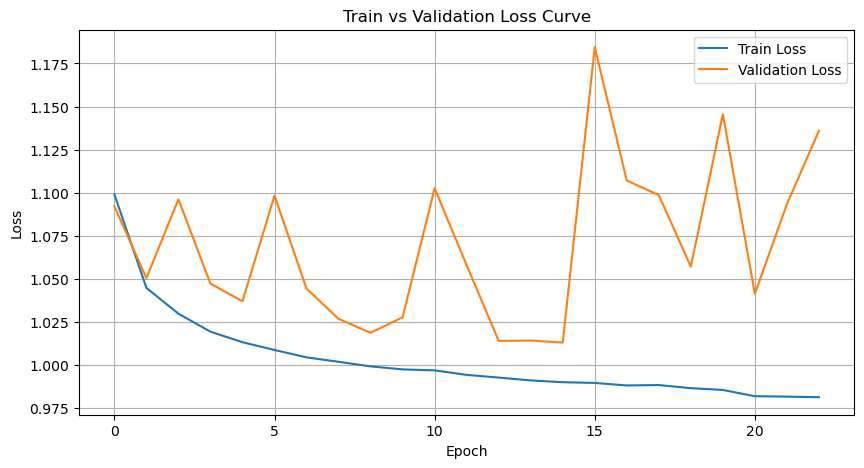

<Figure size 640x480 with 0 Axes>

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history_train, label='Train Loss')
plt.plot(loss_history_val,   label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss Curve")
plt.legend()
plt.grid(True)

plt.show()
plt.gcf().savefig("my_plot.png", dpi=200, bbox_inches='tight')


## Test

In [24]:
# Test evaluation
model.eval()
test_loss = 0.0
test_batches = 0

with torch.no_grad():
    for i in range(0, len(test_indices), batch_size):
        batch_idx = test_indices[i:i+batch_size]

        noisy_batch = noisy_patches_tensor[batch_idx]
        clean_batch = clean_patches_tensor[batch_idx]

        mask_pred = model(noisy_batch)
        enhanced_mag_pred = mask_pred * noisy_batch

        enhanced_log = torch.log(enhanced_mag_pred + eps)
        clean_log    = torch.log(clean_batch + eps)

        loss = criterion(enhanced_log, clean_log)

        test_loss += loss.item()
        test_batches += 1

test_loss /= test_batches
print(f"Final test loss = {test_loss:.6f}")


Final test loss = 0.993886


In [25]:
# Take some samples from test set

num_examples = 8

shuffled_test = test_indices[torch.randperm(len(test_indices))]
example_idx = shuffled_test[:num_examples]

print("Example indices in test set:", example_idx)


Example indices in test set: tensor([18214,  1354, 23122, 19400,  1778,  8808,   162, 19401])


In [26]:
with torch.no_grad():
    noisy_example = noisy_patches_tensor[example_idx]  
    clean_example = clean_patches_tensor[example_idx]

    noisy_example = noisy_example.to(device)
    clean_example = clean_example.to(device)

    mask_pred = model(noisy_example)

    enhanced_mag = mask_pred * noisy_example


noisy_0 shape: (257, 96)


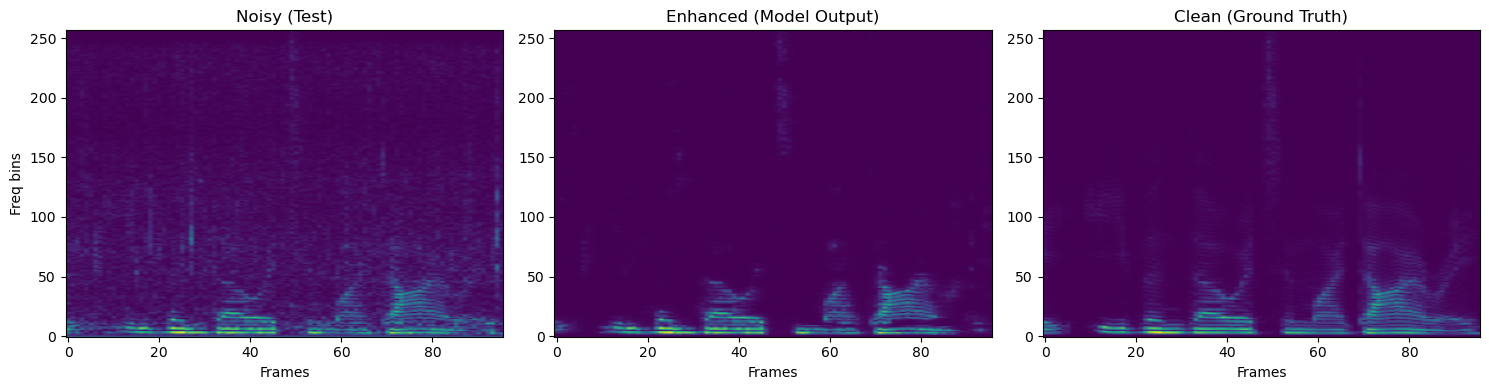

In [27]:
# Take the first sample
noisy_0     = noisy_example[0, 0].detach().cpu().numpy()  # Eliminate the batch and channel dimension
enhanced_0  = enhanced_mag[0, 0].detach().cpu().numpy()
clean_0     = clean_example[0, 0].detach().cpu().numpy()

print("noisy_0 shape:", noisy_0.shape)  # (freq_bins, frames)

# Plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(noisy_0, aspect='auto', origin='lower')
plt.title("Noisy (Test)")
plt.xlabel("Frames")
plt.ylabel("Freq bins")

plt.subplot(1, 3, 2)
plt.imshow(enhanced_0, aspect='auto', origin='lower')
plt.title("Enhanced (Model Output)")
plt.xlabel("Frames")

plt.subplot(1, 3, 3)
plt.imshow(clean_0, aspect='auto', origin='lower')
plt.title("Clean (Ground Truth)")
plt.xlabel("Frames")

plt.tight_layout()
plt.show()


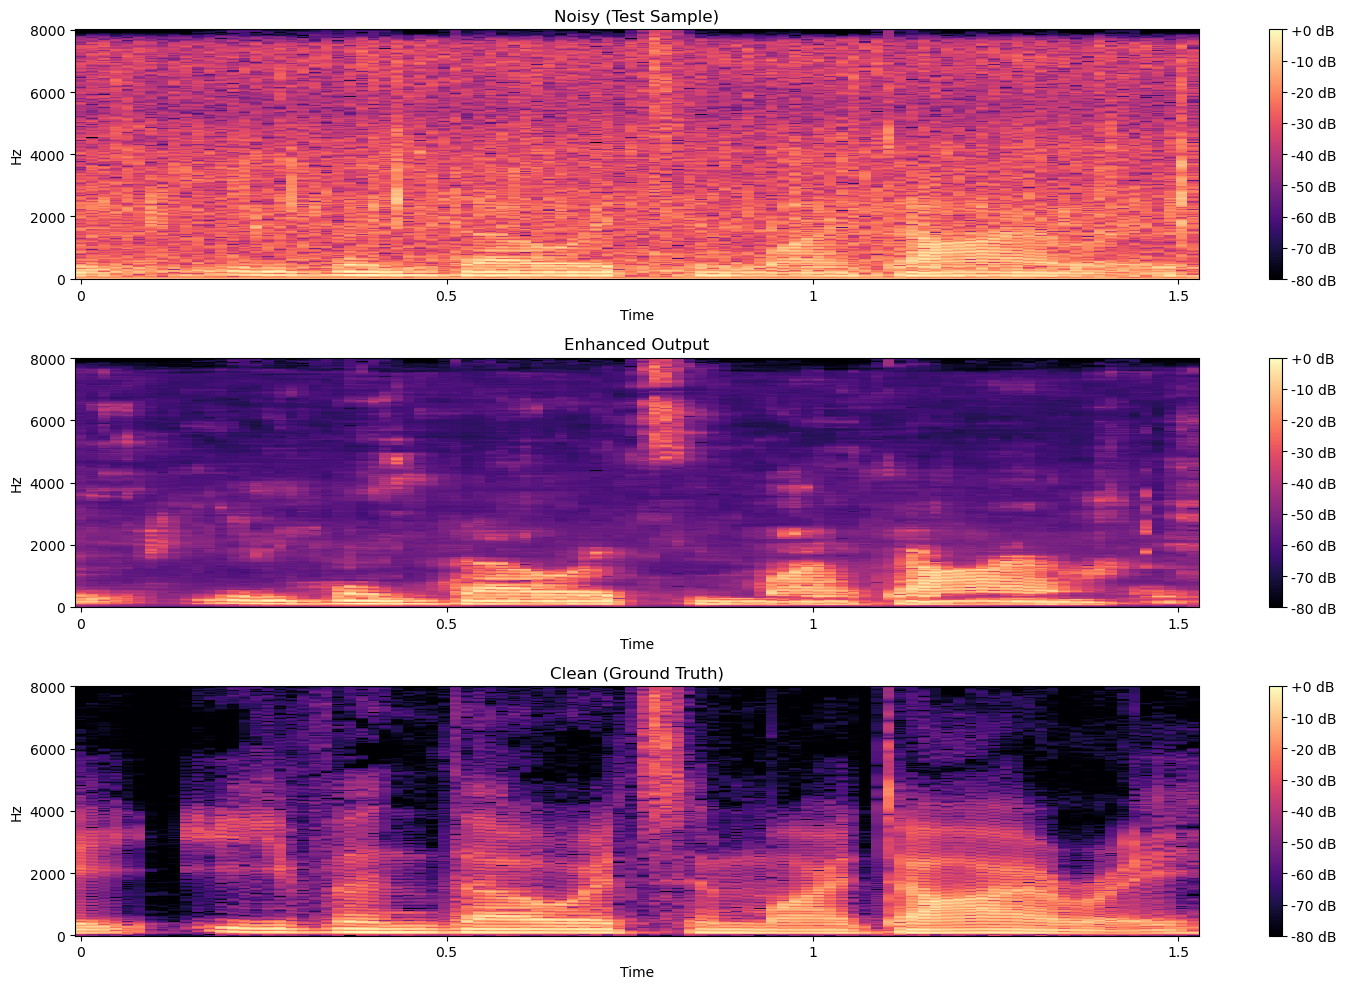

In [32]:
plt.figure(figsize=(15, 10))

# Noisy
plt.subplot(3, 1, 1)
librosa.display.specshow(
    librosa.amplitude_to_db(noisy_0, ref=np.max),
    sr=sample_rate,
    hop_length=hop,
    y_axis="linear",
    x_axis="time",
    cmap="magma"
)
plt.title("Noisy (Test Sample)")
plt.colorbar(format="%+2.0f dB")

# Enhanced
plt.subplot(3, 1, 2)
librosa.display.specshow(
    librosa.amplitude_to_db(enhanced_0, ref=np.max),
    sr=sample_rate,
    hop_length=hop,
    y_axis="linear",
    x_axis="time",
    cmap="magma"
)
plt.title("Enhanced Output")
plt.colorbar(format="%+2.0f dB")

# Clean
plt.subplot(3, 1, 3)
librosa.display.specshow(
    librosa.amplitude_to_db(clean_0, ref=np.max),
    sr=sample_rate,
    hop_length=hop,
    y_axis="linear",
    x_axis="time",
    cmap="magma"
)
plt.title("Clean (Ground Truth)")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


### Test on an unseen audio

In [1]:
# Load the best trained model

class CNNEnhancer(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
        
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output mask
        )

    def forward(self, x):
        # x: [batch, 1, freq_bins, frames]
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNNEnhancer().to(device)
state_dict = torch.load("cnn_enhancer_best.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Loaded model from cnn_enhancer_best.pth")


Using device: cuda
Loaded model from cnn_enhancer_best.pth


C:\Users\mrwho\AppData\Local\Temp\ipykernel_28444\978536415.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("cnn_enhancer_best.pth", map_locatio

In [10]:
# Use the trained model to enhance a clip of new noisy audio, and save into output_path
def enhance_file(input_path, output_path):
    # Load audio file
    y, sr = librosa.load(input_path, sr=sample_rate, mono=True)
    print(f"Loaded {input_path}, duration={len(y)/sr:.2f}s, sr={sr}")

    # STFT
    stft_noisy = librosa.stft(
        y,
        n_fft=n_fft,
        hop_length=hop,
        win_length=win,
        window=window
    )

    mag_noisy = np.abs(stft_noisy)
    phase_noisy = np.angle(stft_noisy)

    mag_tensor = torch.from_numpy(mag_noisy).float().unsqueeze(0).unsqueeze(0).to(device)
    # shape: [1, 1, F, T]

    with torch.no_grad():
        # Predict mask
        mask_pred = model(mag_tensor)               # [1, 1, F, T]
        enhanced_mag = (mask_pred * mag_tensor)[0, 0].cpu().numpy()  # [F, T]

    # Reconstruct the enhanced spectrom
    enhanced_complex = enhanced_mag * np.exp(1j * phase_noisy)

    # ISTFT
    y_enh = librosa.istft(
        enhanced_complex,
        hop_length=hop,
        win_length=win,
        window=window,
        length=len(y)
    )

    # Save audio file
    sf.write(output_path, y_enh, sample_rate)
    print(f"Enhanced audio saved to: {output_path}")


In [11]:
enhance_file("data/test/noisy_test_20250701_01.wav", "data/test/enhanced_test_20250701_01.wav")


Loaded data/test/noisy_test_20250701_01.wav, duration=17.35s, sr=16000
Enhanced audio saved to: data/test/enhanced_test_20250701_01.wav


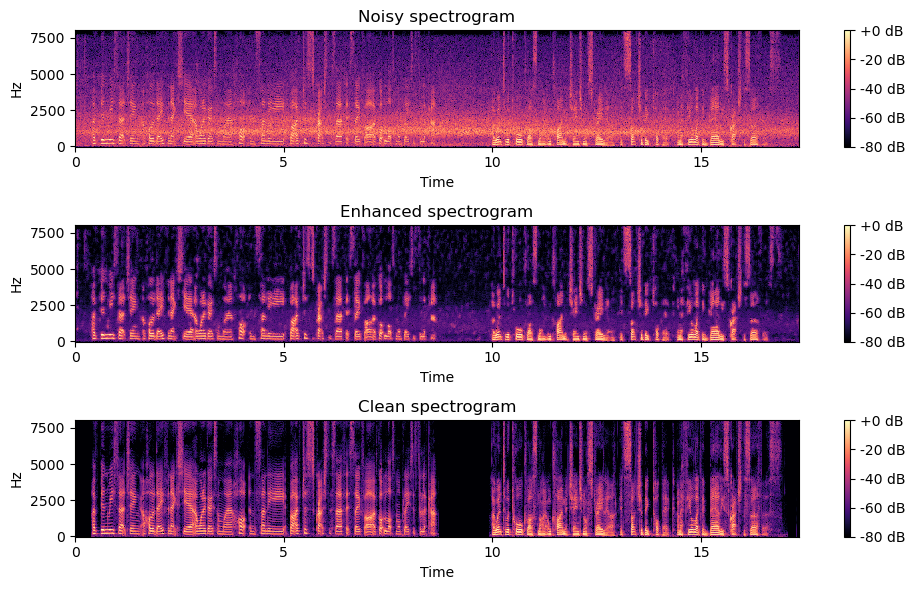

In [13]:
noisy_stft = librosa.stft(
    librosa.load("data/test/noisy_test_20250701_01.wav", sr=sample_rate)[0],
    n_fft=n_fft,
    hop_length=hop,
    win_length=win,
    window=window
)
noisy_mag_vis = np.abs(noisy_stft)

enhanced_stft_vis = librosa.stft(
    librosa.load("data/test/enhanced_test_20250701_01.wav", sr=sample_rate)[0],
    n_fft=n_fft,
    hop_length=hop,
    win_length=win,
    window=window
)
enhanced_mag_vis = np.abs(enhanced_stft_vis)

clean_stft_vis = librosa.stft(
    librosa.load("data/test/clean_test_20250701_01.wav", sr=sample_rate)[0],
    n_fft=n_fft,
    hop_length=hop,
    win_length=win,
    window=window
)
clean_mag_vis = np.abs(clean_stft_vis)

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
librosa.display.specshow(
    librosa.amplitude_to_db(noisy_mag_vis, ref=np.max),
    sr=sample_rate, hop_length=hop, y_axis="linear", x_axis="time"
)
plt.title("Noisy spectrogram")
plt.colorbar(format="%+2.0f dB")

plt.subplot(3, 1, 2)
librosa.display.specshow(
    librosa.amplitude_to_db(enhanced_mag_vis, ref=np.max),
    sr=sample_rate, hop_length=hop, y_axis="linear", x_axis="time"
)
plt.title("Enhanced spectrogram")
plt.colorbar(format="%+2.0f dB")

plt.subplot(3, 1, 3)
librosa.display.specshow(
    librosa.amplitude_to_db(clean_mag_vis, ref=np.max),
    sr=sample_rate, hop_length=hop, y_axis="linear", x_axis="time"
)
plt.title("Clean spectrogram")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()